# LEUMENI TCHOUAMENI LIONEL FLORENT_MASTER PRO_GL0 2 ENSPD_DOUALA CAMEROUN

# TP : Prédiction du taux de désabonnement ou perte de clients


In [2]:
import pandas as pd
import os 
import numpy as np
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, f1_score, ConfusionMatrixDisplay, precision_score, recall_score


# Chargement des données
Le jeu de données se présente sous le format (format .csv), nous utilisons donc 
pandas.read_csv pour charger l'ensemble de données.

In [4]:
# Import dataset and make a CustomerID column to index
os.chdir('C:/Users/user/Desktop/data science/')
df= pd.read_csv('Data_telco.csv',index_col='customerID')

df.head()
df.shape


(7043, 20)

In [46]:
df_columns = df.columns.tolist()
for column in df_columns:
     print(f"{column} unique values : {df[column].unique()}")


gender unique values : ['Female' 'Male']
SeniorCitizen unique values : [0 1]
Partner unique values : ['Yes' 'No']
Dependents unique values : ['No' 'Yes']
tenure unique values : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService unique values : ['No' 'Yes']
MultipleLines unique values : ['No phone service' 'No' 'Yes']
InternetService unique values : ['DSL' 'Fiber optic' 'No']
OnlineSecurity unique values : ['No' 'Yes' 'No internet service']
OnlineBackup unique values : ['Yes' 'No' 'No internet service']
DeviceProtection unique values : ['No' 'Yes' 'No internet service']
TechSupport unique values : ['No' 'Yes' 'No internet service']
StreamingTV unique values : ['No' 'Yes' 'No internet service']
StreamingMovies unique values : ['No' 'Yes' 'No internet service']
Contract unique values : ['Month-to-month' 'O

In [47]:
# Statistic descriptive
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

Il y a quelque chose qui ne va pas avec l'ensemble de données sur la colonne TotalCharges, il doit 
s'agir d'un float et non d'un objet, nous allons donc le changer en float.


In [49]:
# Change TotalCharges to float
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")


# Vérification du mode de paiement

In [50]:
df["PaymentMethod"].unique()


array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Dans le mode de paiement, il y a le mot automatique et nous le supprimerons car si nous visualisons, 
l'étiquette est longue.


In [51]:
# Delete "automatic" from PaymentMethod
df["PaymentMethod"] = df["PaymentMethod"].str.replace(" (automatic)", "", regex=False)

# Valeurs manquantes

In [52]:
features_na = [feature for feature in df.columns if
df[feature].isnull().sum() > 1]
for feature in features_na:
    print(f"{feature}, {round(df[feature].isnull().mean(), 4)} % Missing values")

TotalCharges, 0.0016 % Missing values


Le jeu de données comporte des valeurs manquantes. TotalCharges est de 0,0016 %, ce qui 
représente donc un petit pourcentage.


In [53]:
# Check observation of missing values
df[df[features_na[0]].isnull()]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer,52.55,NaN,No
3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card,56.05,NaN,No
7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No


Comme indiqué ci-dessus, nous voyons que toutes les durées sont nulles, nous supprimerons donc 
les valeurs manquantes.

In [54]:
# Drop missing values
df.dropna(inplace=True)

# Visualisation des variables cibles

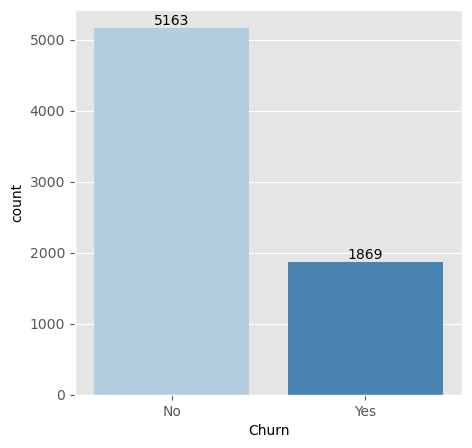

In [55]:
#Apply the ggplot style
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
ax = sns.countplot(x = df["Churn"],palette="Blues")
ax.bar_label(ax.containers[0])
plt.show()


Le graphique à barres suivant montre la variable cible de désabonnement oui et non. La 
proportion de désabonnement est un ensemble de données déséquilibré car les deux classes ne sont 
pas également réparties. Pour y faire face, le rééchantillonnage serait une approche appropriée. Pour 
simplifier les choses, nous conserverons l'ensemble de données déséquilibré et utiliserons de 
nombreuses matrices d'évaluation pour évaluer les modèles.

# Services d'analyse pour chaque client

In [56]:
#Make a function to plot categorical data according to target
def plot_categorical_to_target(df,categorical_values, target):
        number_of_columns = 2
        number_of_rows = math.ceil(len(categorical_values)/2)
        fig = plt.figure(figsize = (12, 5*number_of_rows))
        for index, column in enumerate(categorical_values, 1):
            ax = fig.add_subplot(number_of_rows,number_of_columns,index)
            ax = sns.countplot(x = column, data = df, hue = target, palette="Blues")
        ax.set_title(column)
        return plt.show()





Nous évaluerons un objectif de pourcentage pour chaque colonne de services client 
(PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, 
TechSupport, StreamingTV, StreamingMovies).


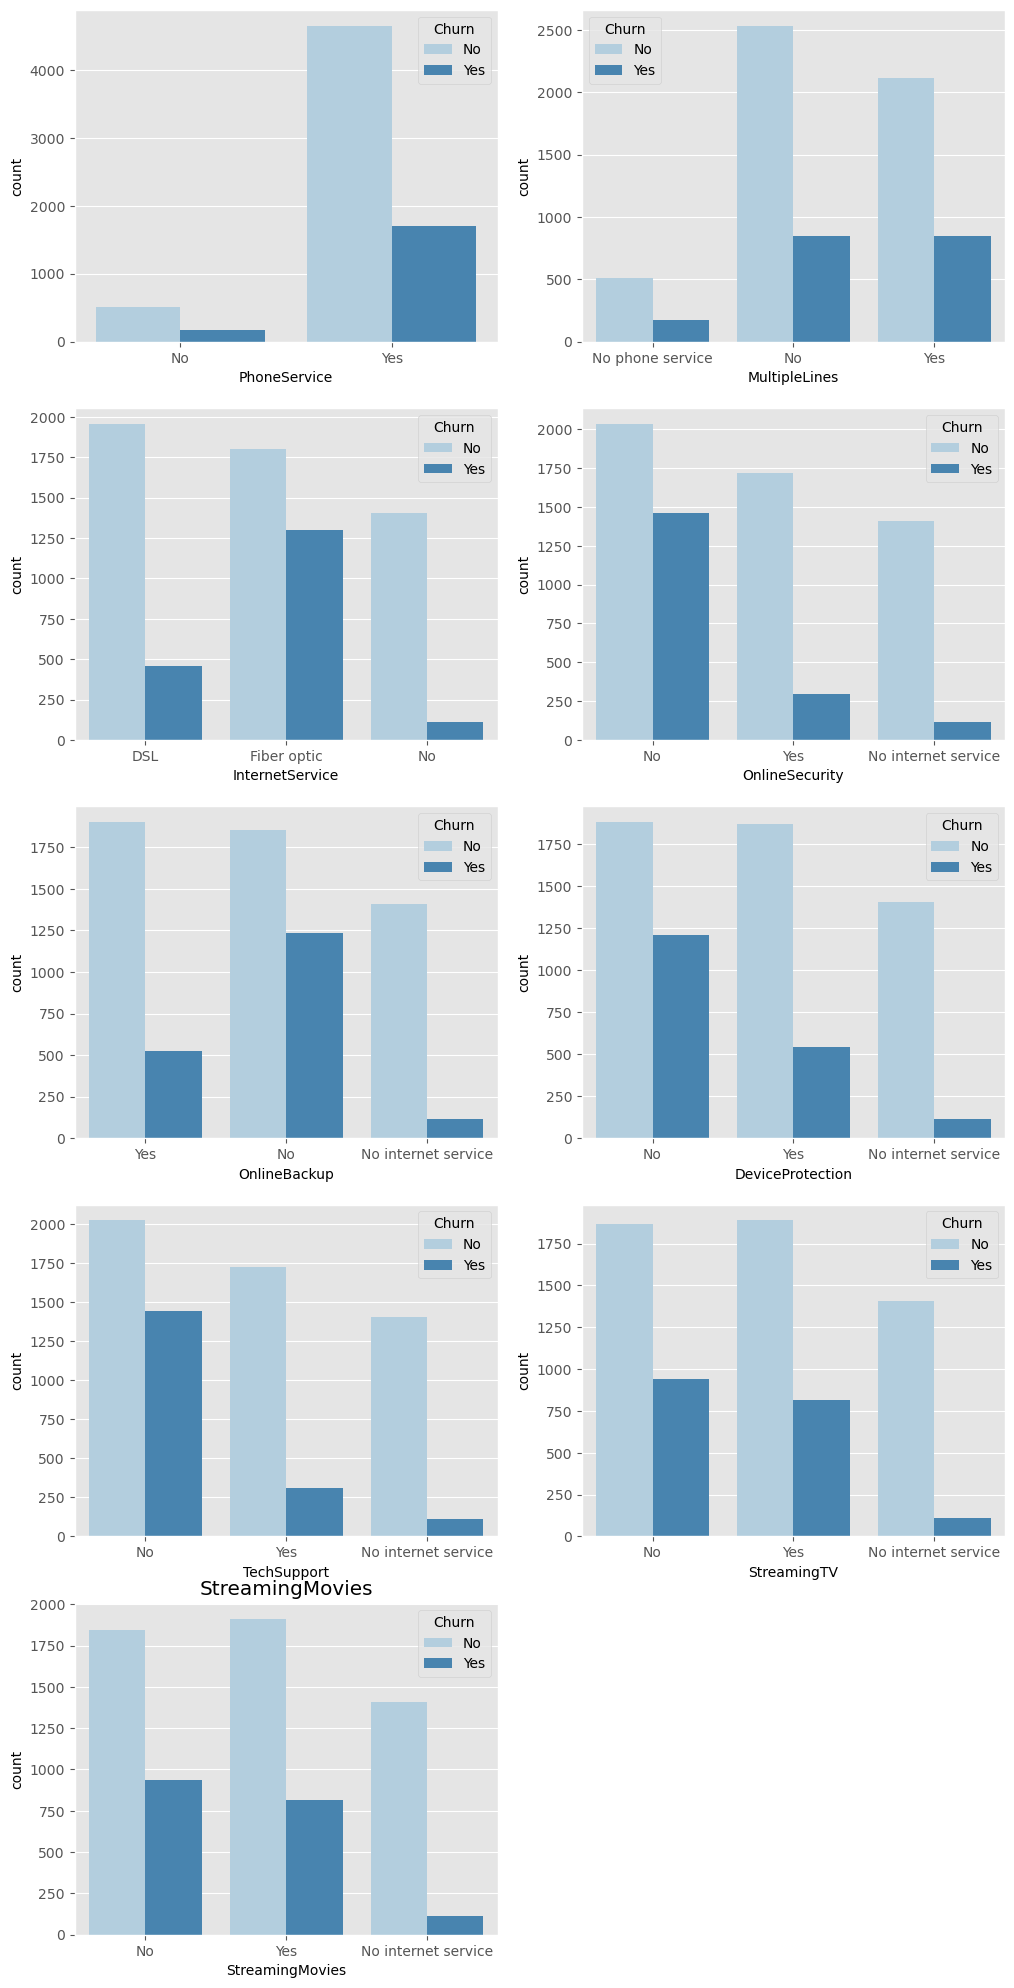

In [57]:
customer_services = ["PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup", "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
plot_categorical_to_target(df,customer_services, "Churn")



# Analyse des informations sur le compte client – Variables catégorielles

Nous évaluerons le pourcentage de désabonnement pour chaque information de compte client 
(Contrat, PaperlessBilling, PaymentMethod)


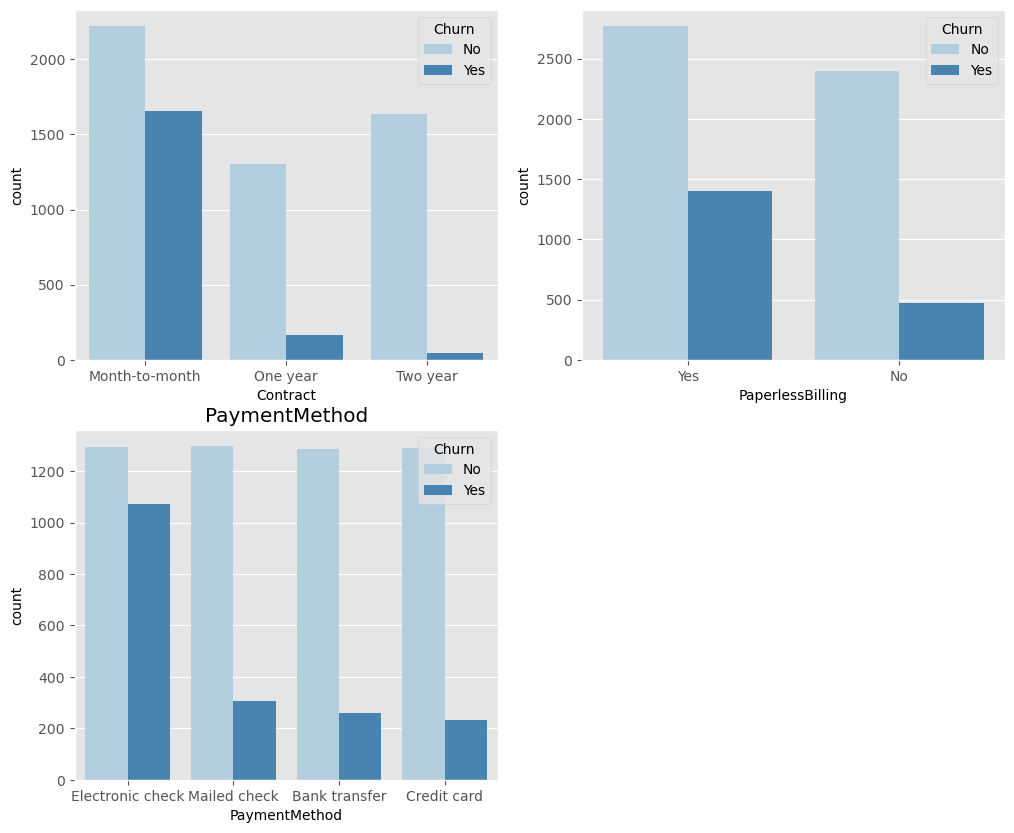

In [58]:
customer_account_cat = ["Contract","PaperlessBilling","PaymentMethod"]
plot_categorical_to_target(df,customer_account_cat,"Churn")

# Analyse des informations sur le compte client – Variables numérique

Nous évaluerons la distribution de chaque variable numérique à partir des informations du compte 
client (mandat, MonthlyCharges, TotalCharges).

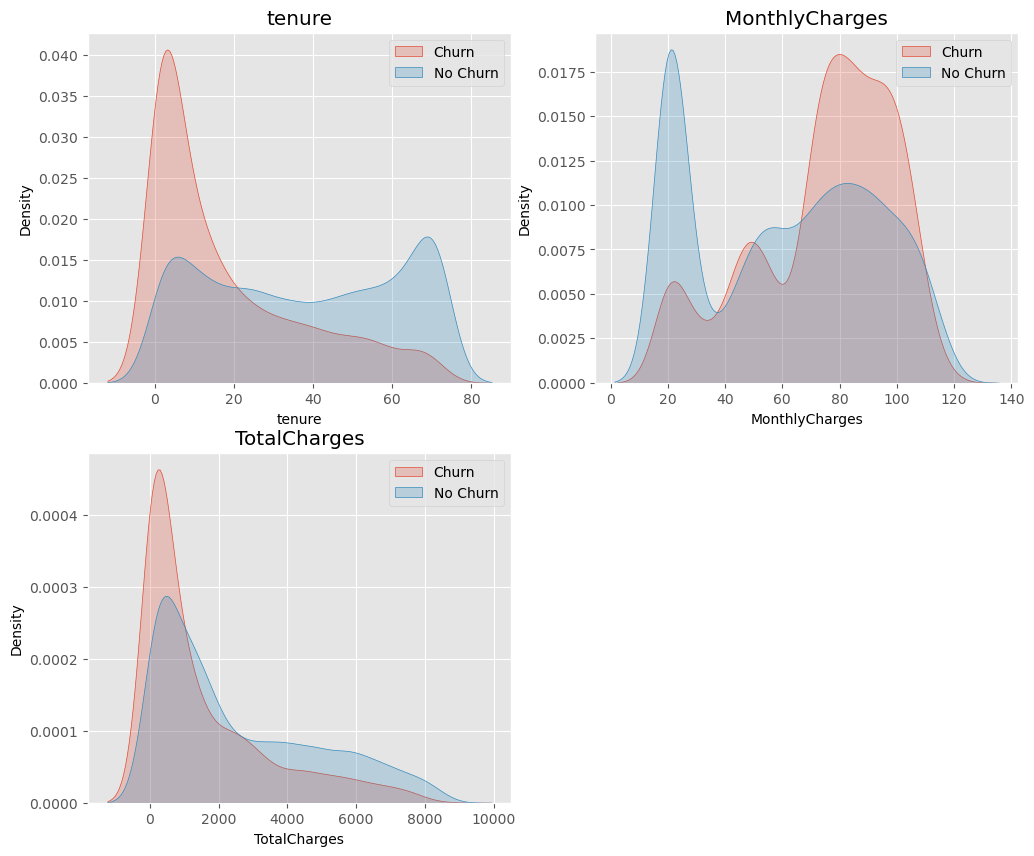

In [59]:
def histogram_plots(df, numerical_values, target):
     number_of_columns = 2
     number_of_rows = math.ceil(len(numerical_values)/2)
     fig = plt.figure(figsize=(12,5*number_of_rows))
     for index, column in enumerate(numerical_values,1):
         ax = fig.add_subplot(number_of_rows, number_of_columns, index)
         ax = sns.kdeplot(df[column][df[target]=="Yes"] ,fill = True)
         ax = sns.kdeplot(df[column][df[target]=="No"], fill = True)
         ax.set_title(column)
         ax.legend(["Churn","No Churn"], loc='upper right')
     plt.savefig("numerical_variables.png", dpi=300)
     return plt.show()
        
customer_account_num = ["tenure", "MonthlyCharges","TotalCharges"]
histogram_plots(df,customer_account_num, "Churn")


# Analyse des informations démographiques du client

Nous évaluerons le pourcentage de taux de désabonnement du client en fonction des 
informations démographiques (sexe, SeniorCitizen, Partner, Dependents)


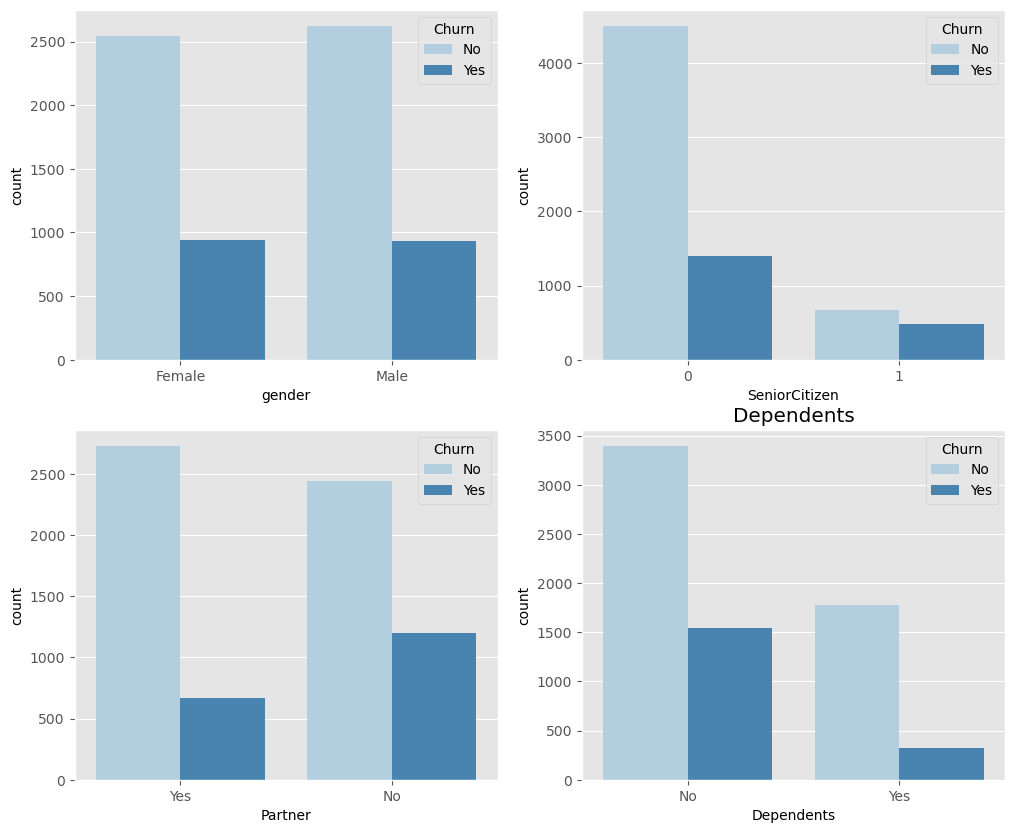

In [60]:
customer_account_cat = ["gender", "SeniorCitizen", "Partner", "Dependents"]
plot_categorical_to_target(df,customer_account_cat,"Churn")

# Vérification des valeurs aberrantes avec Boxplot pour les variables numériques

Une valeur aberrante est un ensemble de données d'observation qui diffère 
considérablement des observations des autres sur l'ensemble de données. Les valeurs aberrantes 
peuvent créer des modèles d'apprentissage automatique avec une faible précision, il est donc 
important de les vérifier. Nous vérifierons les valeurs aberrantes de chaque variable numérique telle 
que la titularisation, les MonthlyCharges et les TotalCharges.

In [61]:
def outlier_check_boxplot(df,numerical_values):
 number_of_columns = 2
 number_of_rows = math.ceil(len(numerical_values)/2)
 
 fig = plt.figure(figsize=(12,5*number_of_rows))
 for index, column in enumerate(numerical_values, 1):
         ax = fig.add_subplot(number_of_rows, number_of_columns, index)
         ax = sns.boxplot(x = column, data = df, palette = "Blues")
         ax.set_title(column)
 plt.savefig("Outliers_check.png", dpi=300)
 return plt.show()
 numerical_values = ["tenure","MonthlyCharges","TotalCharges"]
 outlier_check_boxplot(df,numerical_values)


# Analyse des informations démographiques du client

Nous évaluerons le pourcentage de taux de désabonnement du client en fonction des 
informations démographiques (sexe, SeniorCitizen, Partner, Dependents)


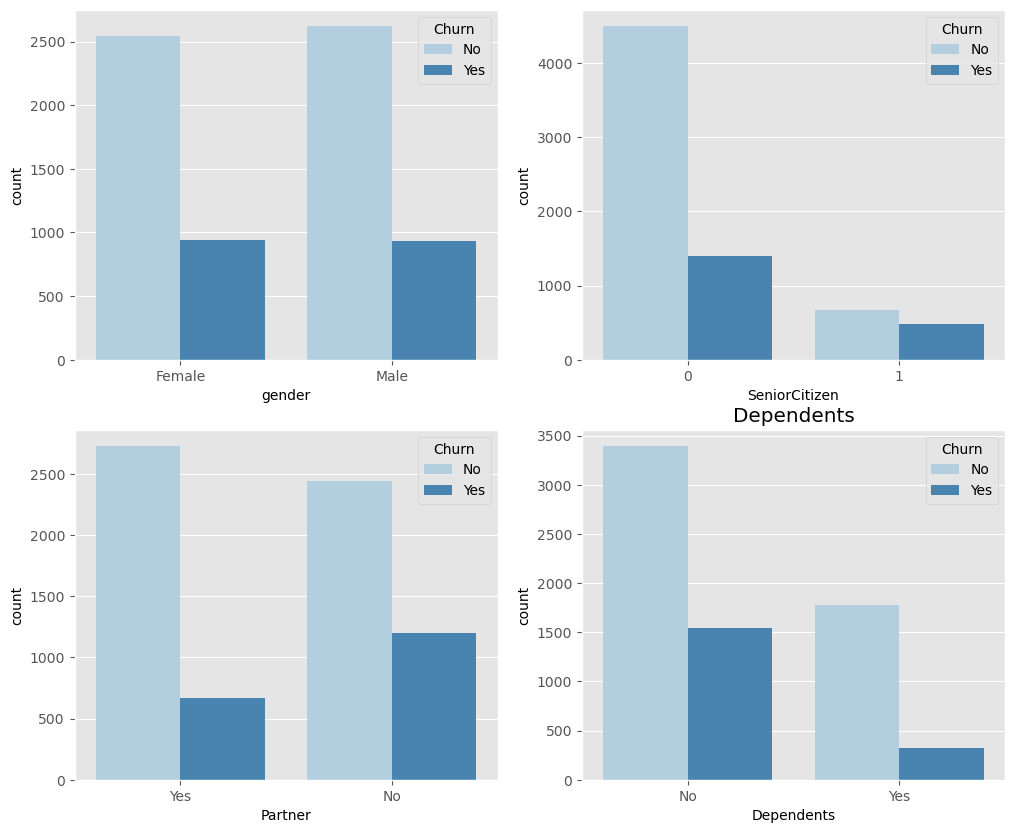

In [62]:
customer_account_cat = ["gender", "SeniorCitizen", "Partner", "Dependents"]
plot_categorical_to_target(df,customer_account_cat,"Churn")

# Vérification des valeurs aberrantes avec Boxplot pour les variables numériques


Une valeur aberrante est un ensemble de données d'observation qui diffère 
considérablement des observations des autres sur l'ensemble de données. Les valeurs aberrantes 
peuvent créer des modèles d'apprentissage automatique avec une faible précision, il est donc 
important de les vérifier. Nous vérifierons les valeurs aberrantes de chaque variable numérique telle 
que la titularisation, les MonthlyCharges et les TotalCharges

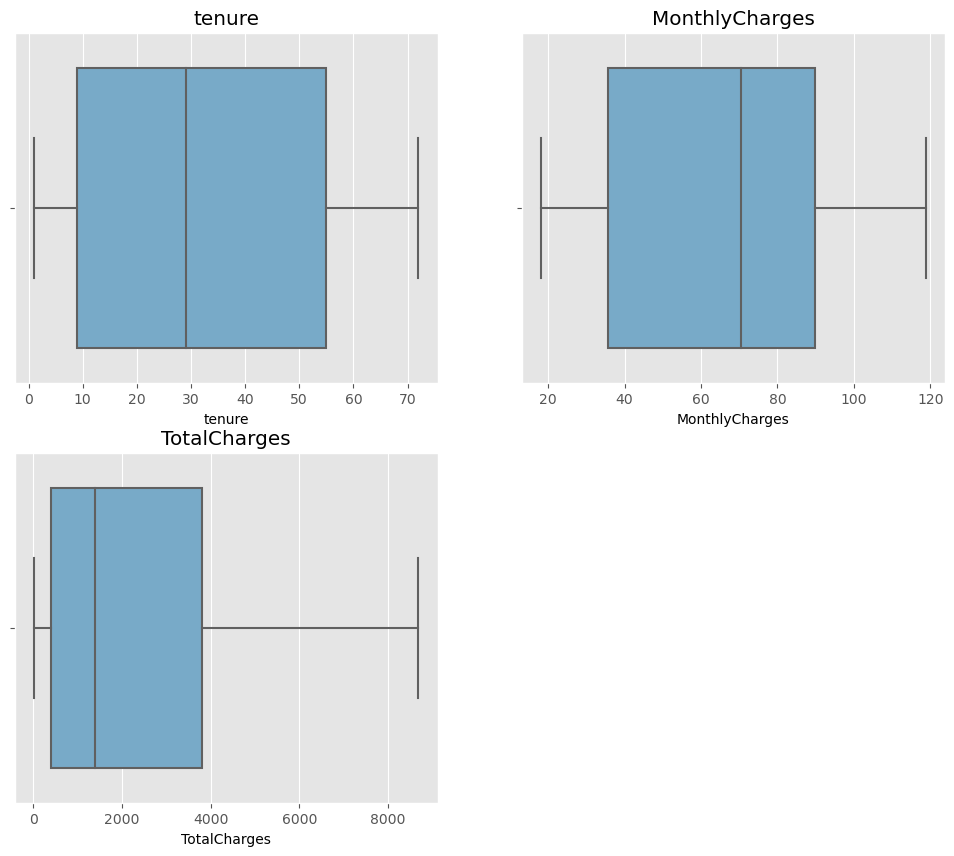

In [63]:
def outlier_check_boxplot(df,numerical_values):
 number_of_columns = 2
 number_of_rows = math.ceil(len(numerical_values)/2)
 
 fig = plt.figure(figsize=(12,5*number_of_rows))
 for index, column in enumerate(numerical_values, 1):
     ax = fig.add_subplot(number_of_rows, number_of_columns, index)
     ax = sns.boxplot(x = column, data = df, palette = "Blues")
     ax.set_title(column)
 plt.savefig("Outliers_check.png", dpi=300)
 return plt.show()
numerical_values = ["tenure","MonthlyCharges","TotalCharges"]
outlier_check_boxplot(df,numerical_values)


À partir des boxplots, nous pouvons conclure que chaque variable numérique n’a pas de valeur 
aberrante.

# Ingénierie des fonctionnalités

Les données brutes peuvent être transformées en fonctionnalités adaptées aux modèles 
d'apprentissage automatique qui traitent ce que l'on appelle l'ingénierie des fonctionnalités. 
L'objectif de l'ingénierie des fonctionnalités est de créer un modèle d'apprentissage automatique 
pour un meilleur apprentissage et obtenir plus de précision. Dans ce TP, nous étiqueterons 
l'encodage pour les variables catégorielles qui ont deux valeurs, un encodage à chaud pour les 
variables catégorielles qui ont plus de deux valeurs et une fonctionnalité appelant des variables 
numériques.

# Encodage des étiquettes

L'encodage des étiquettes vise à convertir les variables catégorielles au format numérique. Dans cet 
article, nous modifierons les variables catégorielles qui ont deux valeurs telles que (Partenaire, 
Personnes à charge, PhoneService, Churn, PaperlessBilling et sexe). Leurs valeurs ont simplement Oui 
ou Non et nous passerons à 1 et 0, sauf que le sexe est Femme à 1 et Homme à 0.

In [64]:
feature_le = ["Partner","Dependents","PhoneService","Churn","PaperlessBilling"]
def label_encoding(df,features):
     for i in features:
         df[i] = df[i].map({"Yes":1, "No":0})
     return df
df = label_encoding(df,feature_le)
df["gender"] = df["gender"].map({"Female":1, "Male":0})


# Encodage à chaud

De même avec l'encodage d'étiquettes, un encodage à chaud change également les variables 
catégorielles en variables numériques. Mais un encodage à chaud prend plus de deux valeurs. Un 
codage à chaud crée une nouvelle colonne entière binaire (1 ou 0) pour chaque niveau de la variable 
catégorielle. Les variables catégorielles qui ont plus de deux valeurs sont (MultipleLines, 
InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, 
StreamingMovies, Contract, PaymentMethod).

In [65]:
features_ohe = ["MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaymentMethod"]
df_ohe = pd.get_dummies(df, columns=features_ohe)


# Mise à l'échelle des fonctionnalités (features)

Dans ce TP, nous utilisons MinMaxScaler pour la mise à l'échelle des fonctionnalités. 
MinMaxScaler peut créer des variables numériques mises à l'échelle de 0 à 1. La mise à l'échelle des 
fonctionnalités est importante pour interpréter les modèles d'apprentissage automatique afin d'avoir 
des fonctionnalités à la même échelle. Nous mettrons à l'échelle les variables numériques telles que 
MonthlyCharges, TotalCharges et tenure (la durée d'occupation).


In [66]:
features_mms = ["tenure","MonthlyCharges","TotalCharges"]
df_mms = pd.DataFrame(df_ohe, columns=features_mms)
df_remaining = df_ohe.drop(columns=features_mms)
mms = MinMaxScaler(feature_range=(0,1))
rescaled_feature = mms.fit_transform(df_mms)
rescaled_feature_df = pd.DataFrame(rescaled_feature, columns=features_mms, 
index=df_remaining.index)
df = pd.concat([rescaled_feature_df,df_remaining],axis=1)

# Analyse de correlation

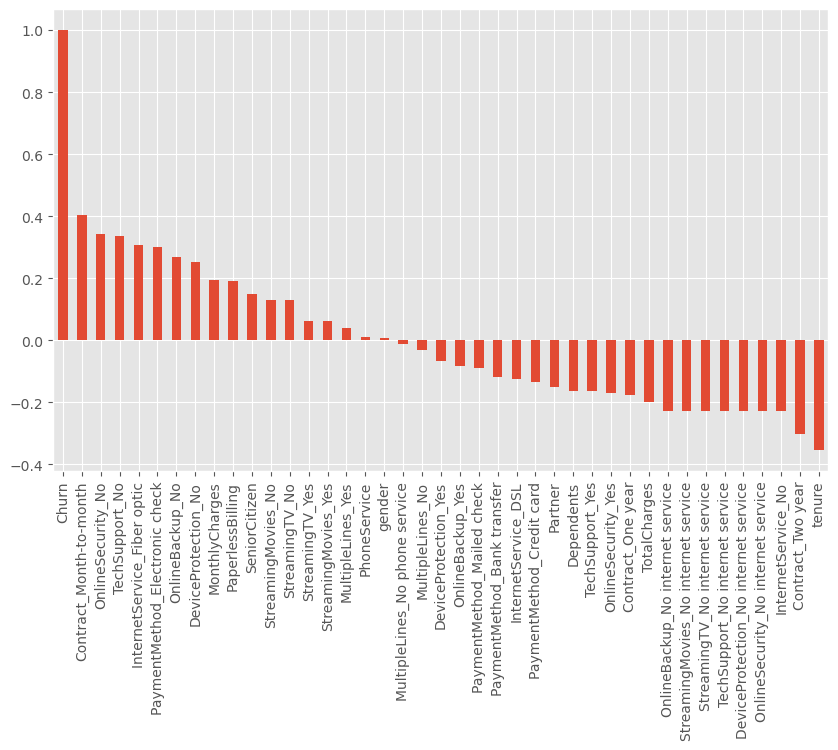

In [67]:
plt.figure(figsize=(10,6))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
plt.savefig("correlation.png", dpi=300)
plt.show()

La corrélation est une méthode statistique permettant de tester la relation entre des 
variables numériques ou catégorielles. Le graphique suivant ci-dessus vise à connaître la corrélation 
entre certaines variables pour cibler le taux de désabonnement des variables. La corrélation la plus 
élevée est la variable Contract_Month-to-month, de sorte que cette variable est ainsi liée au taux de 
désabonnement. L'ancienneté a une corrélation négative avec le taux de désabonnement, de sorte 
que des valeurs plus élevées liées à l'ancienneté entraînent un taux de désabonnement plus faible.

# Répartition des donnée de tests et d’entrainement (test and train)

La répartition des donnée de tests et de train est un processus permettant de valider 
l'ensemble de données et de simuler les performances du modèle avec de nouvelles données. Dans 
ce TP, nous créons 80 % des données de train et 20 % des données de test. La colonne « Churn » que 
nous renommons (le « y ») et la colonne des fonctionnalités que nous renommons (le « X »).

In [68]:
X = df.drop(columns = "Churn")
y = df.Churn
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 40), (1407, 40), (5625,), (1407,))

# Modèle de sélection et d’évaluation

# Création d’une fonction pour afficher les mesures d'évaluation

In [69]:
# For logistic Regression
def feature_weights(X_df, classifier, classifier_name):
     weights = pd.Series(classifier.coef_[0], index = X_df.columns.values).sort_values(ascending=False)
     top_10_weights = weights[:10]
     plt.figure(figsize=(7,6))
     plt.title(f"{classifier_name} - Top 10 Features")
     top_10_weights.plot(kind="bar")

     bottom_10_weights = weights[len(weights)-10:]
     plt.figure(figsize=(7,6))
     plt.title(f"{classifier_name} - Bottom 10 Features")
     bottom_10_weights.plot(kind="bar")
     print("")
    
def confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred, classifier, classifier_name):
     cm = confusion_matrix(y_pred,y_test)
     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
     disp.plot()
     plt.title(f"Confusion Matrix - {classifier_name}")
     plt.show()

     print(f"Accuracy Score Test = {accuracy_score(y_pred,y_test)}")
     print(f"Accuracy Score Train = {classifier.score(X_train,y_train)}")
     return print("\n")

def roc_curve_auc_score(X_test, y_test, y_pred_probabilities,classifier_name):
     y_pred_prob = y_pred_probabilities[:,1]
     fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob)

     plt.plot([0,1],[0,1],"k--")
     plt.plot(fpr,tpr,label=f"{classifier_name}")
     plt.title(f"{classifier_name} - ROC Curve")
     plt.xlabel("False Positive Rate")
     plt.ylabel("True Positive Rate")
     plt.show()
     return print(f"AUC Score (ROC):{roc_auc_score(y_test,y_pred_prob)}")

def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
     y_pred_prob = y_pred_probabilities[:,1]
     precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
     plt.plot(recall,precision, label=f"{classifier_name}")
     plt.title(f"{classifier_name}-ROC Curve")
     plt.xlabel("Recall")
     plt.ylabel("Precision")
     plt.show()
     f1_score_result, auc_score = f1_score(y_test,y_pred), auc(recall,precision)
     return print(f"f1 Score : {f1_score_result} \n AUC Score (PR) :{auc_score}")




# K-Nearest Neighbor

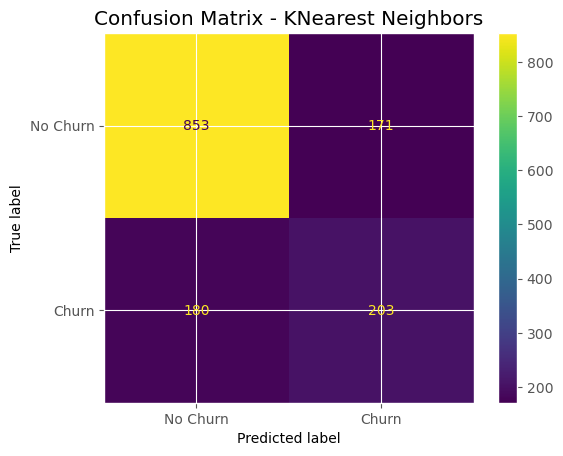

Accuracy Score Test = 0.7505330490405118
Accuracy Score Train = 0.8359111111111112




In [70]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_pred_knn_proba = knn.predict_proba(X_test)

confusion_matrix_plot(X_train,y_train,X_test, y_test, y_pred_knn, knn, "KNearest Neighbors")


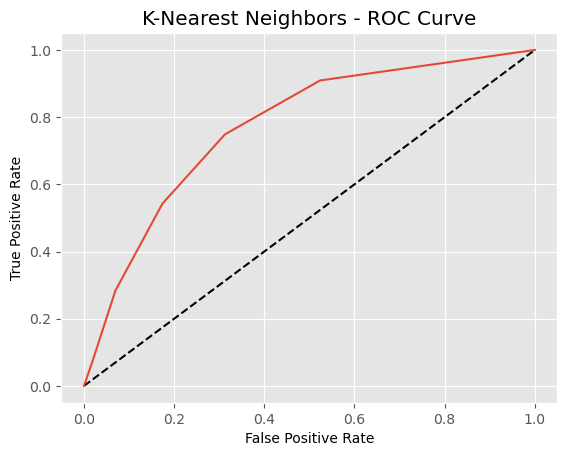

AUC Score (ROC):0.7718769898173121


In [71]:
roc_curve_auc_score(X_test,y_test,y_pred_knn_proba, "K-Nearest Neighbors")


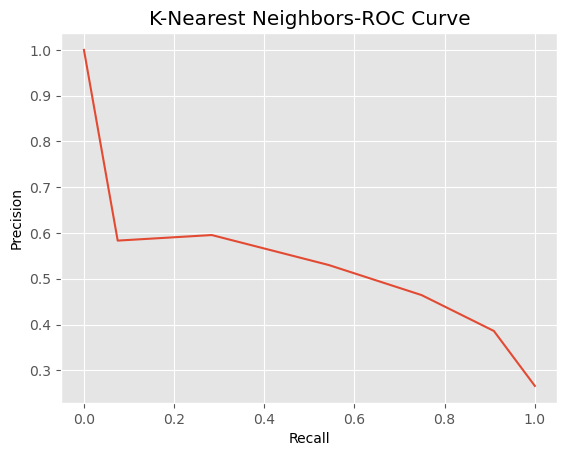

f1 Score : 0.5363276089828268 
 AUC Score (PR) :0.5283439083015596


In [72]:
precision_recall_curve_and_scores(X_test,y_test,y_pred_knn,y_pred_knn_proba,"K-Nearest Neighbors")


# Logistic Regression

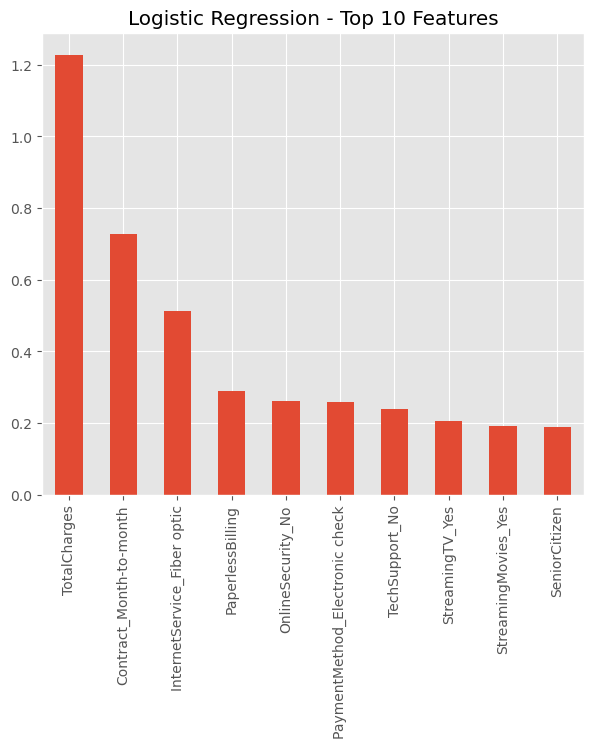

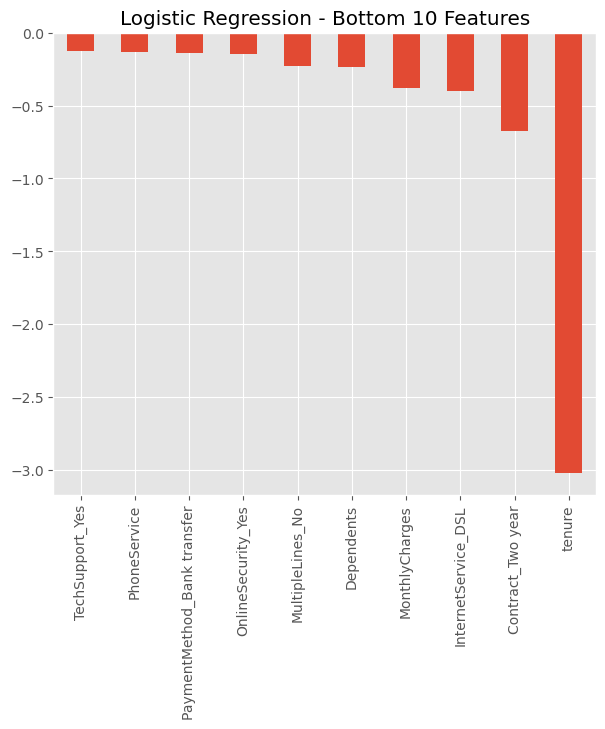

In [73]:
from sklearn.linear_model import LogisticRegression

# Créer et ajuster le modèle de régression logistique
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Appeler la fonction feature_weights() avec logreg
feature_weights(X_train, logreg, "Logistic Regression")


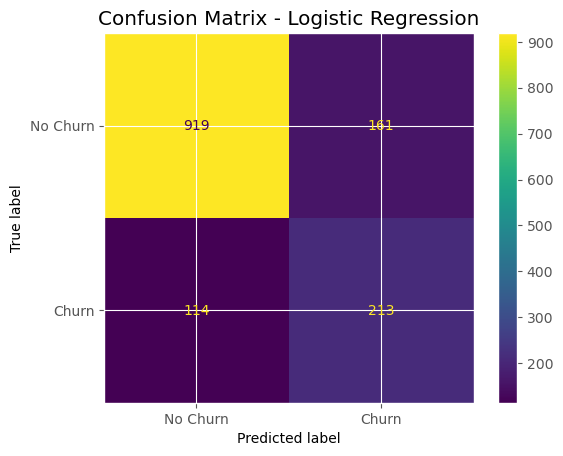

Accuracy Score Test = 0.8045486851457001
Accuracy Score Train = 0.8048




In [75]:
y_pred_train = logreg.predict(X_train)
y_pred_logreg = logreg.predict(X_test)

confusion_matrix_plot(X_train,y_train,X_test,y_test, y_pred_logreg,logreg,"Logistic Regression")


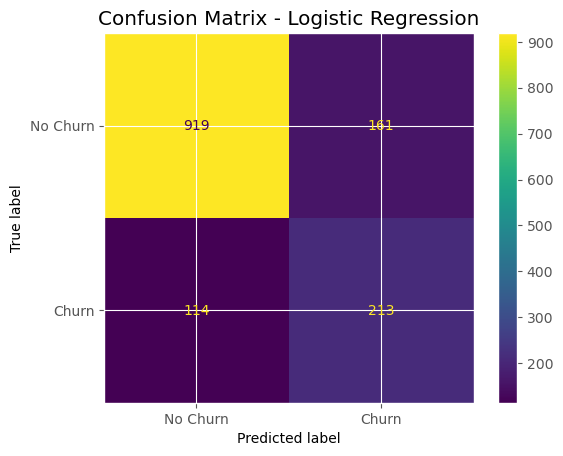

Accuracy Score Test = 0.8045486851457001
Accuracy Score Train = 0.8048




In [76]:
confusion_matrix_plot(X_train,y_train,X_test,y_test, y_pred_logreg,logreg,"Logistic Regression")


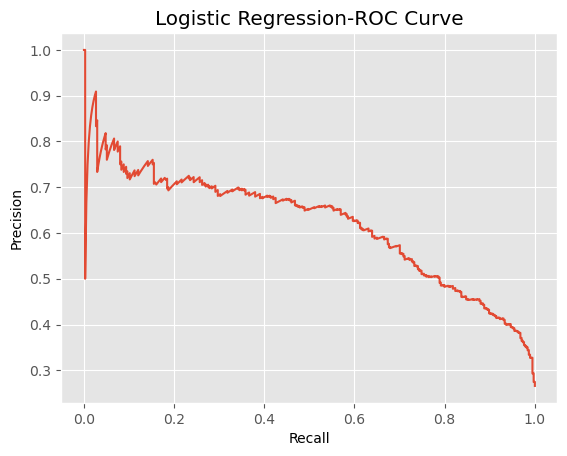

f1 Score : 0.5363276089828268 
 AUC Score (PR) :0.6185957002131842


In [77]:
y_pred_logreg_proba = logreg.predict_proba(X_test)

precision_recall_curve_and_scores(X_test,y_test,y_pred_knn,y_pred_logreg_proba,"Logistic Regression")


# MERCI!!!